# Thông tin sinh viên

Bài tập 2

Tên sinh viên: Nguyễn Phương Tùng

MSSV: 21520524

Euclidean: 9/11

Cosine: 9/11


*   Khi không dùng StandardScaler: 6/11
*   Khi có dùng StandardScaler: 9/11


Correlation: 10/11


# Import thư viện

In [29]:
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from scipy.spatial.distance import cdist

# Hàm của thầy: sobel_filters và calFeatureVector (2)

In [2]:
# Hàm Sobel filters
def sobel_filters(img):
    Sx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = cv2.filter2D(img, -1, Sx)
    Iy = cv2.filter2D(img, -1, Sy)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return Ix, Iy, G, theta

In [3]:
# Hàm tính toán vector đặc trưng
def calFeatureVector(img):
    img_ = cv2.resize(img, (256, 256))
    _, _, G, _ = sobel_filters(img_)
    row_sum = np.sum(G, axis=1, dtype=np.float64).flatten()
    col_sum = np.sum(G, axis=0, dtype=np.float64).flatten()
    return np.hstack((row_sum, col_sum))

# Load dữ liệu

In [4]:
# Kết nối Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Đường dẫn đến thư mục chứa dữ liệu trong Google Drive
data_path = '/content/drive/My Drive/CS231.O22.1/Baitap/Baitap2/images'

In [6]:
# Liệt kê các thư mục train và test
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')

# Kiểm tra lại dữ liệu đã load đúng hay chưa?

In [7]:
# Kiểm tra xem các thư mục đã tồn tại chưa
print("Files in train directory:")
print(os.listdir(train_dir))

Files in train directory:
['tamgiac-1.png', 'tamgiac-2.png', 'tamgiac-3.png', 'tamgiac-4.png', 'tamgiac-5.png', 'tron-1.png', 'tron-2.png', 'tron-3.png', 'tron-4.png', 'tron-5.png', 'chunhat-2.png', 'chunhat-1.png', 'chunhat-3.png', 'chunhat-4.png', 'chunhat-5.png', 'chunhat-6.png']


In [8]:
print("Files in test directory:")
print(os.listdir(test_dir))

Files in test directory:
['tamgiac-1.png', 'tamgiac-2.png', 'tamgiac-3.png', 'tron-1.png', 'tron-2.png', 'chunhat-1.png', 'chunhat-2.png', 'chunhat-3.png', 'tron-3.png', 'chunhat-4.png', 'chunhat-5.png']


## Hàm load đầu tiên để check hình ảnh và label của nó

In [9]:
# Hàm để tải dữ liệu và gán nhãn
def load_data_from_directory_and_check(directory):
    X = []
    y = []
    class_labels = {'chunhat': 0, 'tamgiac': 1, 'tron': 2}

    for filename in os.listdir(directory):
        # Đọc hình ảnh
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))  # Resize ảnh về kích thước cố định
        img = img.astype('float32') / 255.0  # Chuẩn hóa ảnh

        # Gán nhãn dựa trên tên file
        if filename.startswith('chunhat'):
            label = class_labels['chunhat']
        elif filename.startswith('tamgiac'):
            label = class_labels['tamgiac']
        elif filename.startswith('tron'):
            label = class_labels['tron']
        else:
            continue

        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)

In [10]:
# Tải dữ liệu train
X_train, y_train = load_data_from_directory_and_check(train_dir)

# Tải dữ liệu test
X_test, y_test = load_data_from_directory_and_check(test_dir)

In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16, 256, 256, 3)
y_train shape: (16,)
X_test shape: (11, 256, 256, 3)
y_test shape: (11,)


Training images:


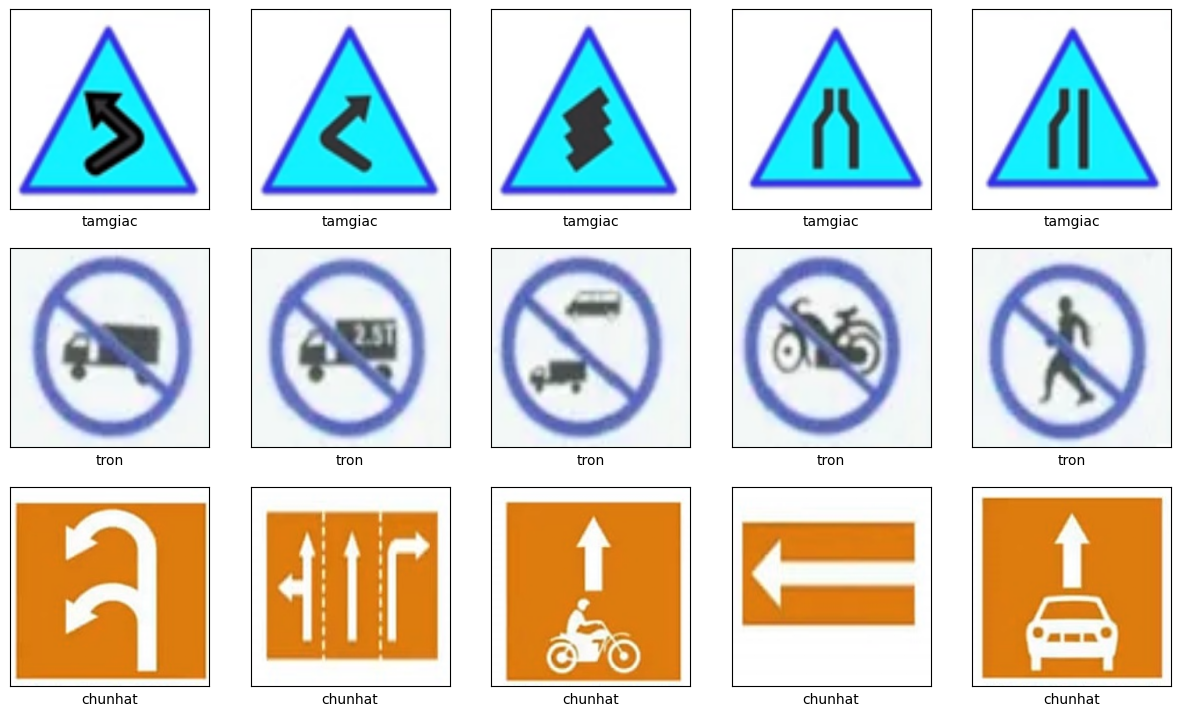

Testing images:


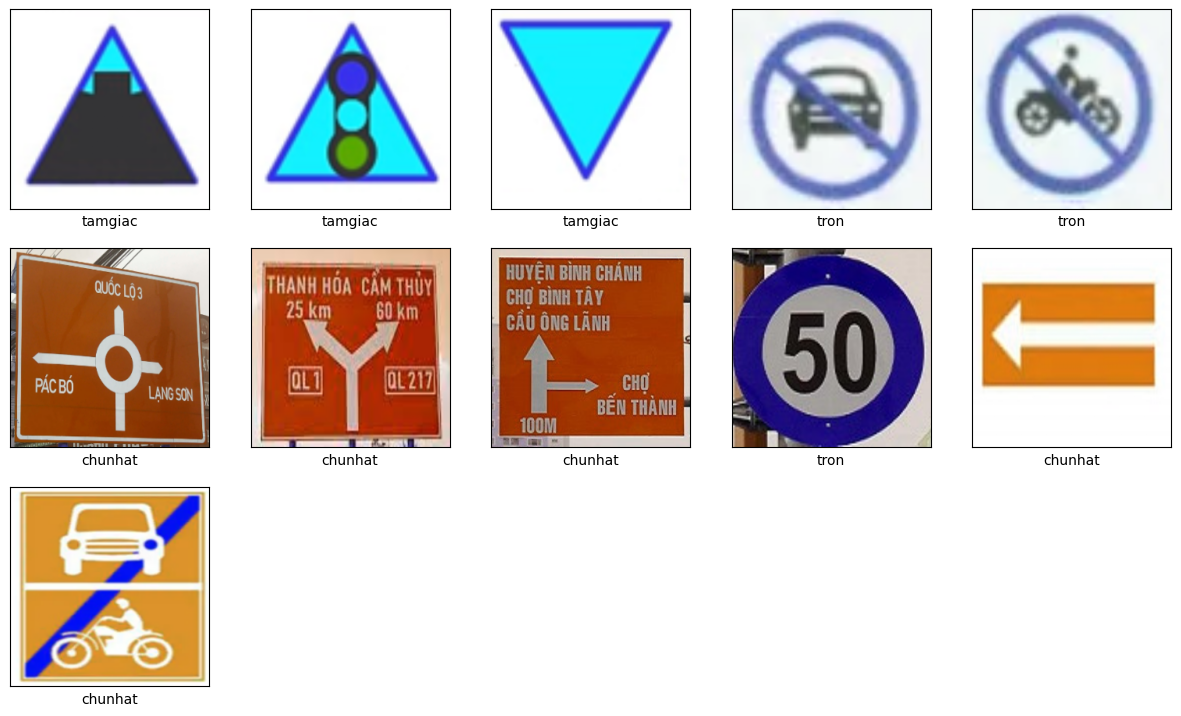

In [12]:
# Hàm để hiển thị hình ảnh cùng với nhãn
def plot_images_with_labels(images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

# Class labels
class_names = ['chunhat', 'tamgiac', 'tron']

# Hiển thị một số hình ảnh từ tập train cùng với nhãn
print("Training images:")
plot_images_with_labels(X_train, y_train, class_names, num_images=15)

# Hiển thị một số hình ảnh từ tập test cùng với nhãn
print("Testing images:")
plot_images_with_labels(X_test, y_test, class_names, num_images=15)

**Nhận xét:** 100% biển báo được gán đúng với nhãn tương ứng của nó (trong cả tập train và test).

## Hàm load thứ 2 có dùng calFeatureVector để tính toán đặc trưng

In [13]:
# Hàm để tải dữ liệu và gán nhãn
def load_data_from_directory(directory):
    X = []
    y = []
    class_labels = {'chunhat': 0, 'tamgiac': 1, 'tron': 2}

    for filename in os.listdir(directory):
        # Đọc hình ảnh
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (256, 256))  # Resize ảnh về kích thước cố định
            img = img.astype('float32') / 255.0  # Chuẩn hóa ảnh

            # Gán nhãn dựa trên tên file
            if filename.startswith('chunhat'):
                label = class_labels['chunhat']
            elif filename.startswith('tamgiac'):
                label = class_labels['tamgiac']
            elif filename.startswith('tron'):
                label = class_labels['tron']
            else:
                continue

            # Tính toán vector đặc trưng
            feature_vector = calFeatureVector(img)
            X.append(feature_vector)
            y.append(label)

    return np.array(X), np.array(y)

In [14]:
# Tải dữ liệu train
X_train, y_train = load_data_from_directory(train_dir)

# Tải dữ liệu test
X_test, y_test = load_data_from_directory(test_dir)

In [15]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16, 1536)
y_train shape: (16,)
X_test shape: (11, 1536)
y_test shape: (11,)


In [19]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Dùng độ đo cdist với thăm số "euclidean"

In [53]:
# Tải dữ liệu train
X_train, y_train = load_data_from_directory(train_dir)

# Tải dữ liệu test
X_test, y_test = load_data_from_directory(test_dir)

# Chuẩn hóa dữ liệu
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
"""

'scaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n\n# Áp dụng PCA để giảm chiều dữ liệu\npca = PCA(n_components=10)\nX_train = pca.fit_transform(X_train)\nX_test = pca.transform(X_test)\n'

In [54]:
# Tính khoảng cách giữa các mẫu test và train sử dụng cdist
distances = cdist(X_test, X_train, 'euclidean')

In [55]:
# Xác định nhãn của mẫu test dựa trên nhãn của mẫu train gần nhất
nearest_indices = np.argmin(distances, axis=1)
y_pred = y_train[nearest_indices]

In [56]:
# Đánh giá độ chính xác của mô hình phân loại
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['chunhat', 'tamgiac', 'tron']))

Accuracy: 0.8181818181818182
Classification Report:
               precision    recall  f1-score   support

     chunhat       1.00      0.80      0.89         5
     tamgiac       0.75      1.00      0.86         3
        tron       0.67      0.67      0.67         3

    accuracy                           0.82        11
   macro avg       0.81      0.82      0.80        11
weighted avg       0.84      0.82      0.82        11



In [57]:
# In ra số lượng mẫu trong tập test dự đoán chính xác
correct_predictions = np.sum(y_pred == y_test)
print("Number of correct predictions:", correct_predictions)

Number of correct predictions: 9


# Dùng độ đo cdist với tham số "cosine"

## Không chuẩn hóa

In [58]:
# Tải dữ liệu train
X_train, y_train = load_data_from_directory(train_dir)

# Tải dữ liệu test
X_test, y_test = load_data_from_directory(test_dir)

# Chuẩn hóa dữ liệu
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
"""

'scaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n\n# Áp dụng PCA để giảm chiều dữ liệu\npca = PCA(n_components=10)\nX_train = pca.fit_transform(X_train)\nX_test = pca.transform(X_test)\n'

In [59]:
# Tính khoảng cách giữa các mẫu test và train sử dụng cdist
distances = cdist(X_test, X_train, 'cosine')

In [60]:
# Xác định nhãn của mẫu test dựa trên nhãn của mẫu train gần nhất
nearest_indices = np.argmin(distances, axis=1)
y_pred = y_train[nearest_indices]

In [61]:
# Đánh giá độ chính xác của mô hình phân loại
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['chunhat', 'tamgiac', 'tron']))

Accuracy: 0.5454545454545454
Classification Report:
               precision    recall  f1-score   support

     chunhat       1.00      0.60      0.75         5
     tamgiac       0.00      0.00      0.00         3
        tron       0.38      1.00      0.55         3

    accuracy                           0.55        11
   macro avg       0.46      0.53      0.43        11
weighted avg       0.56      0.55      0.49        11



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
# In ra số lượng mẫu trong tập test dự đoán chính xác
correct_predictions = np.sum(y_pred == y_test)
print("Number of correct predictions:", correct_predictions)

Number of correct predictions: 6


## Có chuẩn hóa


In [68]:
# Tải dữ liệu train
X_train, y_train = load_data_from_directory(train_dir)

# Tải dữ liệu test
X_test, y_test = load_data_from_directory(test_dir)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [69]:
# Tính khoảng cách giữa các mẫu test và train sử dụng cdist
distances = cdist(X_test, X_train, 'cosine')

In [70]:
# Xác định nhãn của mẫu test dựa trên nhãn của mẫu train gần nhất
nearest_indices = np.argmin(distances, axis=1)
y_pred = y_train[nearest_indices]

In [71]:
# In ra số lượng mẫu trong tập test dự đoán chính xác
correct_predictions = np.sum(y_pred == y_test)
print("Number of correct predictions:", correct_predictions)

Number of correct predictions: 9


# Dùng độ đo cdist với tham số "correlation"

In [63]:
# Tải dữ liệu train
X_train, y_train = load_data_from_directory(train_dir)

# Tải dữ liệu test
X_test, y_test = load_data_from_directory(test_dir)

# Chuẩn hóa dữ liệu
"""scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Áp dụng PCA để giảm chiều dữ liệu
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
"""

'scaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n\n# Áp dụng PCA để giảm chiều dữ liệu\npca = PCA(n_components=10)\nX_train = pca.fit_transform(X_train)\nX_test = pca.transform(X_test)\n'

In [64]:
# Tính khoảng cách giữa các mẫu test và train sử dụng cdist
distances = cdist(X_test, X_train, 'correlation')

In [65]:
# Xác định nhãn của mẫu test dựa trên nhãn của mẫu train gần nhất
nearest_indices = np.argmin(distances, axis=1)
y_pred = y_train[nearest_indices]

In [66]:
# Đánh giá độ chính xác của mô hình phân loại
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['chunhat', 'tamgiac', 'tron']))

Accuracy: 0.9090909090909091
Classification Report:
               precision    recall  f1-score   support

     chunhat       1.00      1.00      1.00         5
     tamgiac       1.00      0.67      0.80         3
        tron       0.75      1.00      0.86         3

    accuracy                           0.91        11
   macro avg       0.92      0.89      0.89        11
weighted avg       0.93      0.91      0.91        11



In [67]:
# In ra số lượng mẫu trong tập test dự đoán chính xác
correct_predictions = np.sum(y_pred == y_test)
print("Number of correct predictions:", correct_predictions)

Number of correct predictions: 10


# Model: Random Forest

In [20]:
# Thiết lập tham số cho Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [21]:
# Khởi tạo Grid Search với Random Forest
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Huấn luyện mô hình
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [22]:
# In ra tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [23]:
# Dự đoán trên tập kiểm tra
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

In [24]:
# In kết quả đánh giá
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['chunhat', 'tamgiac', 'tron']))

Accuracy: 0.8181818181818182
Classification Report:
               precision    recall  f1-score   support

     chunhat       0.71      1.00      0.83         5
     tamgiac       1.00      0.67      0.80         3
        tron       1.00      0.67      0.80         3

    accuracy                           0.82        11
   macro avg       0.90      0.78      0.81        11
weighted avg       0.87      0.82      0.82        11

